###### License

 Copyright 2020 Google LLC

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.

# Consent-based Conversion Adjustments


In this notebook, we are illustrating how we can use a non-parametric model (based on k nearest-neighbors) to redistribute conversion values of customers opting out of advertising cookies over customers who opt in. 
The resulting conversion-value adjustments can be used within value-based bidding to prevent biases in the bidding-algorithm due to systematic differences between customers who opt in vs customers who don't.

# Imports

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/consent-based-conversion-adjustments/blob/main/cocoa/cocoa_template.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/consent-based-conversion-adjustments/blob/main/cocoa/cocoa_template.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
!pip install git+https://github.com/google/consent-based-conversion-adjustments.git
from IPython.display import clear_output

clear_output()


In [ ]:
from itertools import combinations
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


np.random.seed(123)  

In [ ]:
from consent_based_conversion_adjustments.cocoa import nearest_consented_customers

# Data Simulation

In [ ]:
#@title Create fake dataset of adgroups and conversion values
#@markdown We are generating random data: each row is an individual conversion
#@markdown with a given conversion value. \
#@markdown For each conversion, we know the
#@markdown adgroup, which is our only feature here and just consists of 3 letters.

n_consenting_customers = 8000  #@param
n_nonconsenting_customers = 2000  #@param


def simulate_conversion_data_consenting_non_consenting(
    n_consenting_customers: int,
    n_nonconsenting_customers: int) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
  """Simulates dataframes for consenting and non-consenting customers.

    Args:
      n_consenting_customers: Desired number of consenting customers. Should be
        larger than n_nonconsenting_customers.
      n_nonconsenting_customers: Desired number non non-consenting customers.

    Returns:
      Two dataframes of simulated consenting and non-consenting customers.
  """
  fake_adgroups = np.array(
      ['_'.join(fake_ad) for fake_ad in (combinations('ABCDEFG', 3))])

  data_consenting = pd.DataFrame.from_dict({
      'adgroup':
          fake_adgroups[np.random.randint(
              low=0, high=len(fake_adgroups), size=n_consenting_customers)],
      'conversion_value':
          np.random.lognormal(1, size=n_consenting_customers)
  })

  data_nonconsenting = pd.DataFrame.from_dict({
      'adgroup':
          fake_adgroups[np.random.randint(
              low=0, high=len(fake_adgroups), size=n_nonconsenting_customers)],
      'conversion_value':
          np.random.lognormal(1, size=n_nonconsenting_customers)
  })
  return data_consenting, data_nonconsenting


data_consenting, data_nonconsenting = simulate_conversion_data_consenting_non_consenting(
    n_consenting_customers, n_nonconsenting_customers)
data_consenting.head()

,adgroup,conversion_value
0,A_B_E,3.513415
1,C_E_F,3.156282
2,E_F_G,9.720625
3,B_C_F,2.249506
4,B_D_E,0.513649


# Preprocessing

In [ ]:
#@title Split adgroups in separate levels
#@markdown We preprocess our data. Consenting and non-consenting data are
#@markdown concatenated to ensure that they have the same feature-columns. \
#@markdown We then split our adgroup-string into its components and dummy code each.
#@markdown The level of each letter in the adgroup-string is added as prefix here.

def preprocess_data(data_consenting, data_nonconsenting):
  data_consenting['consent'] = 1
  data_nonconsenting['consent'] = 0
  data_all = pd.concat([data_consenting, data_nonconsenting])
  data_all.reset_index(inplace=True)

  # split the adgroups in their levels and dummy-code those.
  data_all = data_all.join(
      pd.get_dummies(data_all['adgroup'].str.split('_').apply(pd.Series)))
  data_all.drop(['adgroup'], axis=1, inplace=True)
  return data_all[data_all['consent'] == 1], data_all[data_all['consent'] == 0]

data_consenting, data_nonconsenting = preprocess_data(data_consenting,
                                                      data_nonconsenting)
data_consenting.head()

,index,conversion_value,consent,0_A,0_B,0_C,0_D,0_E,1_B,1_C,1_D,1_E,1_F,2_C,2_D,2_E,2_F,2_G
0,0,3.513415,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,1,3.156282,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
2,2,9.720625,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
3,3,2.249506,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
4,4,0.513649,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0


# Create NearestCustomerMatcher object and run conversion-adjustments.

We now have our fake data in the right format – similarity here depends alone on
the adgroup of a given customer. In reality, we would have a gCLID and a
timestamp for each customer that we could pass as `id_columns` to the matcher.\
Other example features that could be used instead/in addition to the adgroup are


* device type
* geo
* time of day
* ad-type
* GA-derived features
* etc. 

When using the `NearestCustomerMatcher`, we can choose between three matching
strategies:
* if we define `number_nearest_neighbors`, a fixed number of nearest (consenting)
customers is used, irrespective of how dissimilar those customers are to the 
seed-non-consenting customer.
* if we define `radius`, all consenting customers that fall within the specified radius of a non-consenting customer are used. This means that the number of nearest-neighbors likely differs between non-consenting customers, and a given non-consenting customer might have no consenting customers in their radius.
* if we define `percentage`, the `NearestCustomerMatcher` first which minimal radius needs to be set in order to find at least one closest consenting customer for at least `percentage` non-consenting customers (not implemented in beam yet)

In practice, the simplest approach is to set `number_nearest_neighbors` and
choose a sufficiently high number here to ensure that individual consenting
customers do not receive too high a share of non-consenting conversion values.



In [ ]:
matcher = nearest_consented_customers.NearestCustomerMatcher(
    data_consenting, conversion_column='conversion_value', id_columns=['index'])
data_adjusted = matcher.calculate_adjusted_conversions(
    data_nonconsenting, number_nearest_neighbors=100)

In [ ]:
#@title We generated a new dataframe containing the conversion-value adjustments
data_adjusted.sample(5)

,index,conversion_value,adjusted_conversion,average_distance,n_added_conversions,sum_distribution_weights,naive_adjusted_conversion
1329,1329,1.155288,0.000000,NaN,0,0.00,2.311220
2845,2845,9.008280,2.918920,1.0,52,0.52,10.164212
2674,2674,0.188782,0.000000,NaN,0,0.00,1.344715
7544,7544,5.218837,0.000000,NaN,0,0.00,6.374770
2433,2433,2.648813,2.391943,1.0,53,0.53,3.804746


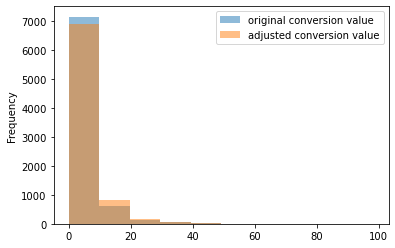

In [ ]:
#@title Visualise distribution of adjusted conversions
#@markdown We can plot the original and adjusted (original + adjustment-values)
#@markdown conversion values and see that in general, the distributions are
#@markdown very similar, but as expected, the adjusted values are shifted towards
#@markdown larger values.
ax = data_adjusted['conversion_value'].plot(kind='hist', alpha=.5, )
(data_adjusted['adjusted_conversion']+data_adjusted['conversion_value']).plot(kind='hist', ax=ax, alpha=.5)
ax.legend(['original conversion value', 'adjusted conversion value'])
plt.show()

# Next steps
The above would run automatically on a daily basis within a Google Cloud Project. A new table ready to use with Offline Conversion Import is created.
If no custom pipeline has been set up yet, we recommend using [Tentacles](https://github.com/GoogleCloudPlatform/cloud-for-marketing/blob/master/marketing-analytics/activation/gmp-googleads-connector/README.md).